# LARRY scLT dataset processing
- Sample: LARRY-HEMO-D4
- Author: Yiming Chao @HKU & CTSCB
- Update: 2025-6-19

# pre-processing of larry barcode

In [1]:
import gzip, time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

def is_valid(bc):
    return (bc[4:6]=='TG'
            and bc[10:12]=='CA' 
            and bc[16:18]=='AC' 
            and bc[22:24]=='GA' 
            and bc[28:30]=='GT'
            and bc[34:36]=='AG')

def in_filtered_list(cell_bc, filtered_cell_barcodes):
    num_Ns = sum([c=='N' for c in cell_bc])
    if num_Ns > 1: return False
    elif num_Ns == 1: return np.any([cell_bc.replace('N',c) in filtered_cell_barcodes for c in 'ACTG'])
    else: return cell_bc in filtered_cell_barcodes

In [5]:
larry_prefix = 'GTTGCTAGGAGAGACCATATG'
N_READS = 10
N_UMIS = 3
N_HAMMING = 3

output_prefix = 'Larry_day-4'

sample_paths = {
    'Larry_day-4': {
        'filtered_cell_barcodes_path':'/mnt/yiming/nfs_share/larry/Larry-D4/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
        'larry_barcode_fastq_paths':[
            '/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_1.fastq.gz',
            '/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_2.fastq.gz'
        ]
    }
}

In [34]:
counts = {}

for sample,paths in sample_paths.items():
    filtered_cell_barcodes = gzip.open(paths['filtered_cell_barcodes_path']).read().decode('utf-8').split('\n')
    filtered_cell_barcodes_set = set(filtered_cell_barcodes)

    for fastq_path in paths['larry_barcode_fastq_paths']:
        R1 = gzip.open('/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_1.fastq.gz')
        R2 = gzip.open('/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_2.fastq.gz')
        counter = 0
        start_time = time.time()
        while True:
            counter += 1
            if counter % 1000000 == 0: print(fastq_path+ ': Processed {} lines in {} seconds'.format(counter, time.time()-start_time))
            try:
                r1_line = R1.readline().decode('utf-8')
                r2_line = R2.readline().decode('utf-8')
            except:
                print('ERROR extracting {}'.format(fastq_path))
                break
            if r2_line == '': break
            if r2_line[0] in '@+': continue
            if larry_prefix in r2_line:
                larry_bc = r2_line.split(larry_prefix)[1][:40]
                cell_bc = r1_line[:16]+'-1'
                umi = r1_line[16:24]
                if is_valid(larry_bc) and in_filtered_list(cell_bc, filtered_cell_barcodes):
                    combo = (sample, cell_bc, umi, larry_bc)
                    if combo in counts:
                        counts[combo] += 1
                    else:
                        counts[combo] = 1

/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_1.fastq.gz: Processed 1000000 lines in 11.918915271759033 seconds
/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_1.fastq.gz: Processed 2000000 lines in 23.8742573261261 seconds
/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_2.fastq.gz: Processed 1000000 lines in 11.96716833114624 seconds
/mnt/yiming/nfs_share/SugimuraRR_UCSO_CPOS-240606-RRS-23942a/subset_larry-amplicon_2.fastq.gz: Processed 2000000 lines in 24.039995670318604 seconds


In [2]:
# Load the object from the file
with open('Larry_day4_barcode.pkl', 'rb') as file:
    counts = pickle.load(file)

In [5]:
counts

{('Larry_day-4',
  'CATGAGTTCACTACTT-1',
  'GAATGAGC',
  'CCGGTGTCAACAACGAACACCCGATAGCGTGCTTAGTCTC'): 218,
 ('Larry_day-4',
  'GACAGCCAGATTCGCT-1',
  'TAGTGTTC',
  'TCGCTGTCATCAAGTCACTTCGGAAAGCGTCTACAGTACA'): 224,
 ('Larry_day-4',
  'TGTGGCGTCAAGGCTT-1',
  'TTAAATCG',
  'TACCTGTGACCACCGTACGGTTGATACGGTAAGCAGAATG'): 144,
 ('Larry_day-4',
  'TGCATGAAGAGAGCCT-1',
  'TGGTACAT',
  'AAGCTGTCTGCAAGCCACCTCCGATTGAGTCGTCAGTGCT'): 212,
 ('Larry_day-4',
  'CTAAGTGTCGAAACAA-1',
  'ACCGGCGG',
  'ATCTTGAAGTCATGTAACCTCTGAGTGAGTACCAAGGTCG'): 358,
 ('Larry_day-4',
  'TTCCTAAAGAGCCATG-1',
  'CACACCTG',
  'GACGTGTTAACAACCCACTCACGATGCTGTCTGGAGATCC'): 124,
 ('Larry_day-4',
  'TATACCTCAAGCGGAT-1',
  'CTTCTGTA',
  'TGATTGACTACATAAAACACGGGAAATAGTTATAAGCATT'): 258,
 ('Larry_day-4',
  'CAGTGCGAGATGTAGT-1',
  'AAATTGCA',
  'CAAGTGCTTGCAGCACACCGTTGAGCTCGTAAGGAGGAGA'): 376,
 ('Larry_day-4',
  'ACTATGGTCGAACACT-1',
  'AAGACGCC',
  'TAAGTGCAGACAAGCAACGGCCGAGAACGTGTCAAGCCTG'): 234,
 ('Larry_day-4',
  'ATCGTGAGTCCGGTGT-

In [3]:
len(counts)

8756668

In [13]:
N_READS = 30
N_UMIS = 3
N_HAMMING = 3

Retaining 1739607 out of 8756668 (Sample,Cell-BC,UMI,GFP-BC) combinations


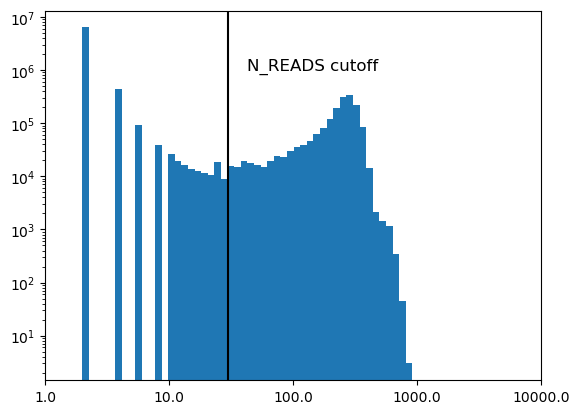

In [14]:
num_reads = [v for k,v in counts.items()]
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.axvline(np.log(N_READS)/np.log(10),c='k')
plt.xticks(range(5),np.logspace(0,4,5))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**6,'N_READS cutoff', fontsize=12)
plt.yscale('log')

counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

In [15]:
def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
good_gfp_bcs = []
bc_map = {}
for i,bc1 in enumerate(all_gfp_bcs):
    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2
            break
    if not mapped:
        good_gfp_bcs.append(bc1)

print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc

Mapped 500 out of 7889 barcodes
Mapped 1000 out of 7889 barcodes
Mapped 1500 out of 7889 barcodes
Mapped 2000 out of 7889 barcodes
Mapped 2500 out of 7889 barcodes
Mapped 3000 out of 7889 barcodes
Mapped 3500 out of 7889 barcodes
Mapped 4000 out of 7889 barcodes
Mapped 4500 out of 7889 barcodes
Mapped 5000 out of 7889 barcodes
Mapped 5500 out of 7889 barcodes
Mapped 6000 out of 7889 barcodes
Mapped 6500 out of 7889 barcodes
Mapped 7000 out of 7889 barcodes
Mapped 7500 out of 7889 barcodes

Collapsed 4228 barcodes



Final annotation has 2934 clones in 5023 cells


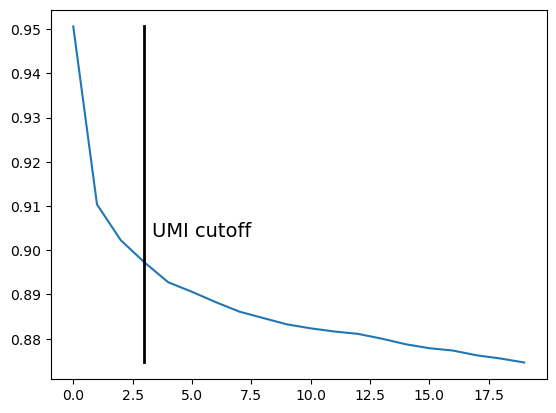

In [16]:
cell_data = {}
for sample,paths in sample_paths.items():
    filtered_cell_barcodes = gzip.open(paths['filtered_cell_barcodes_path']).read().decode('utf-8').split('\n')
    for cell_bc in filtered_cell_barcodes:
        cell_data[(sample,cell_bc)] = {}

for sample,cell_bc,umi,larry_bc in counts_filtered.keys():
    if (sample,cell_bc) in cell_data:
        if not larry_bc in cell_data[(sample,cell_bc)]:
            cell_data[(sample,cell_bc)][larry_bc] = 0
        cell_data[(sample,cell_bc)][larry_bc] += 1

num_cells_with_barcode = np.zeros(20)
for larry_bc_counts in cell_data.values():
    if len(larry_bc_counts)>0:
        num_cells_with_barcode[:np.min([20,np.max(list(larry_bc_counts.values()))])] += 1
efficiency = num_cells_with_barcode / len(cell_data)
plt.plot(range(20),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = {}
for k,larry_bc_counts in cell_data.items():
    final_BCs[k] = '-'.join(sorted([k for k,v in larry_bc_counts.items() if v >= N_UMIS]))
print('\nFinal annotation has '+repr(len(set(final_BCs.values())))+' clones in '+repr(len([k for k,v in final_BCs.items() if len(v)>0]))+' cells')

In [17]:
output = []
for sample,paths in sample_paths.items():
    filtered_cell_barcodes = gzip.open(paths['filtered_cell_barcodes_path']).read().decode('utf-8').split('\n')
    for cell_bc in filtered_cell_barcodes:
        output.append(sample+','+cell_bc+','+final_BCs[(sample,cell_bc)])
open(output_prefix+'.larry_d4_clones-240930.csv','w').write('\n'.join(output))

457437

# h5ad file processing

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=100,color_map='Reds')
sc.logging.print_version_and_date()

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
plt.show()
matplotlib.rcParams.update({'figure.figsize': (6,6)})

Running Scanpy 1.10.3, on 2024-11-20 12:03.


In [2]:
adata = sc.read_10x_h5('/mnt/yiming/nfs_share/larry/Larry-D4/outs/filtered_feature_bc_matrix.h5')

/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
scrublet_result = pd.read_csv('/mnt/yiming/nfs_share/larry/Larry-D4/outs/filtered_feature_bc_matrix/scrublet_table.tsv', 
                             sep='\t', index_col=0)

In [4]:
scrublet_dict = scrublet_result['label_frac'].to_dict()
adata.obs['scrublet_result'] = adata.obs.index.map(scrublet_dict)

In [5]:
adata = adata[adata.obs['scrublet_result'] == False]

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

/tmp/ipykernel_3714751/347420258.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


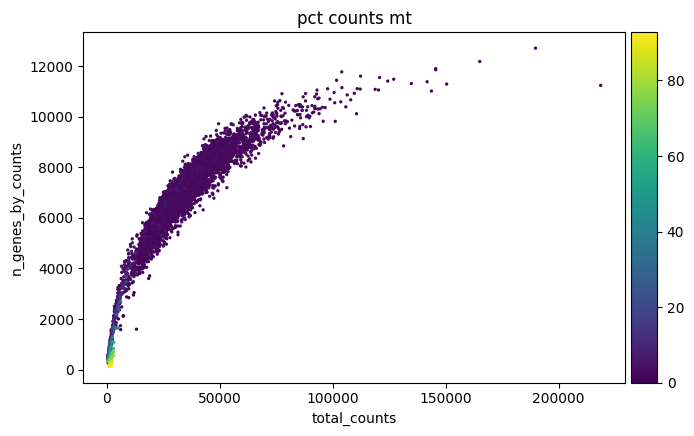

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


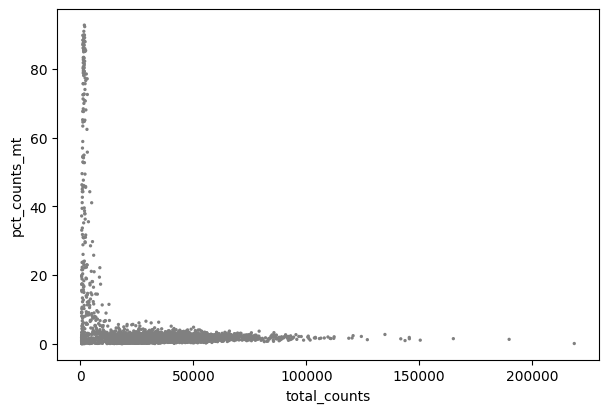

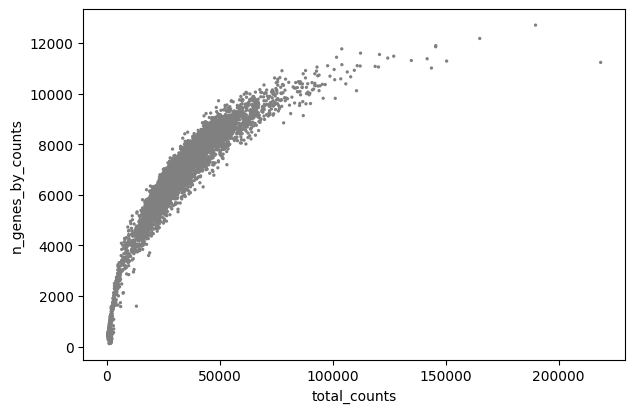

In [9]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 10000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

/mnt/yiming/nfs_share/anaconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata.var_names_make_unique()

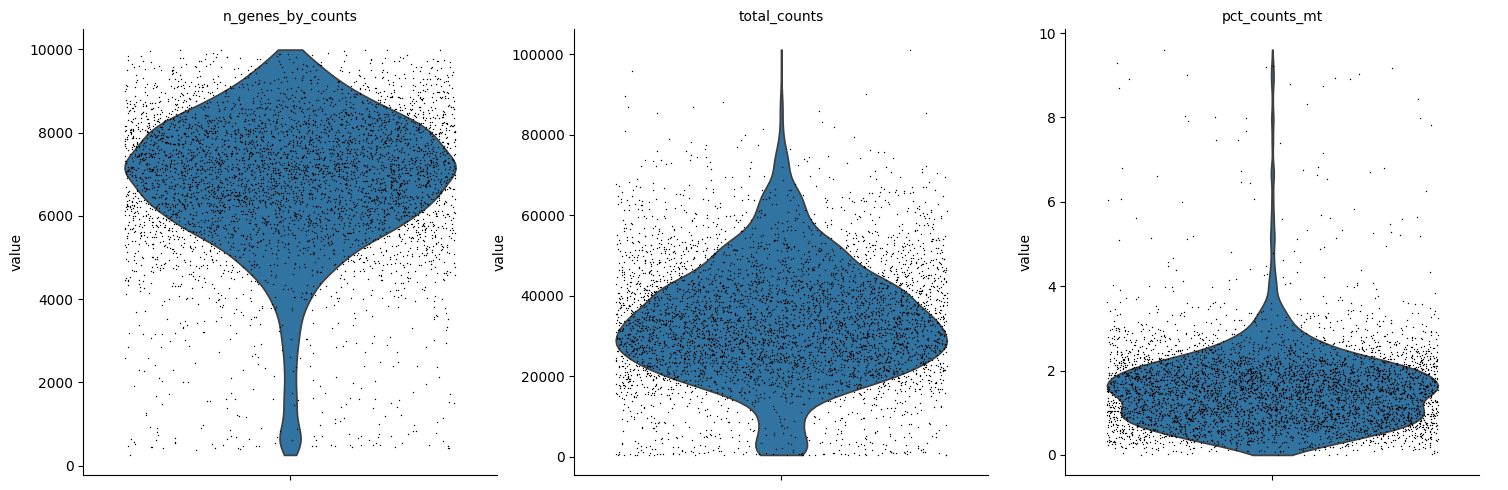

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [13]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [14]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

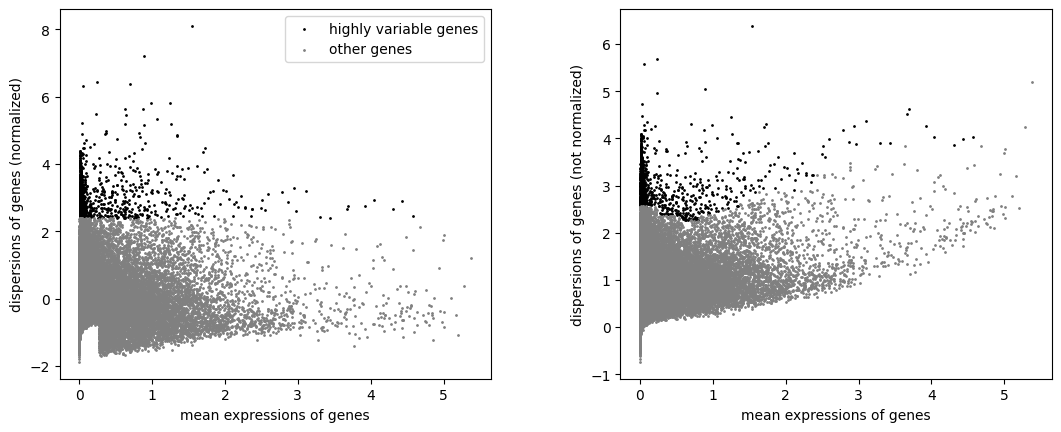

In [16]:
sc.pl.highly_variable_genes(adata)

In [11]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, n_iterations=2, resolution=5)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering
    finished: found 42 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


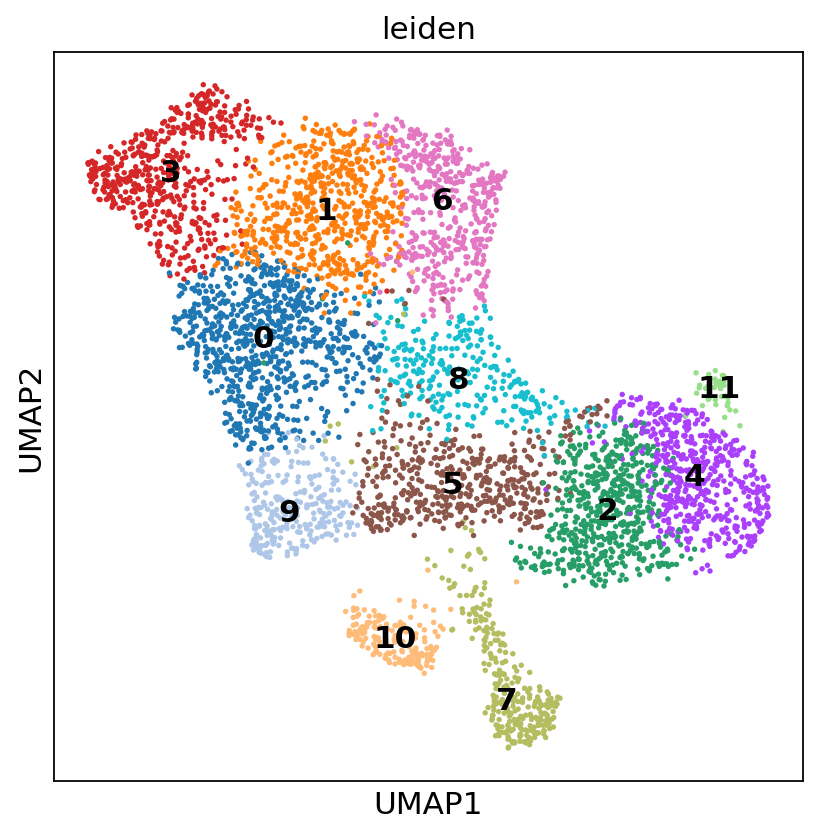

In [8]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

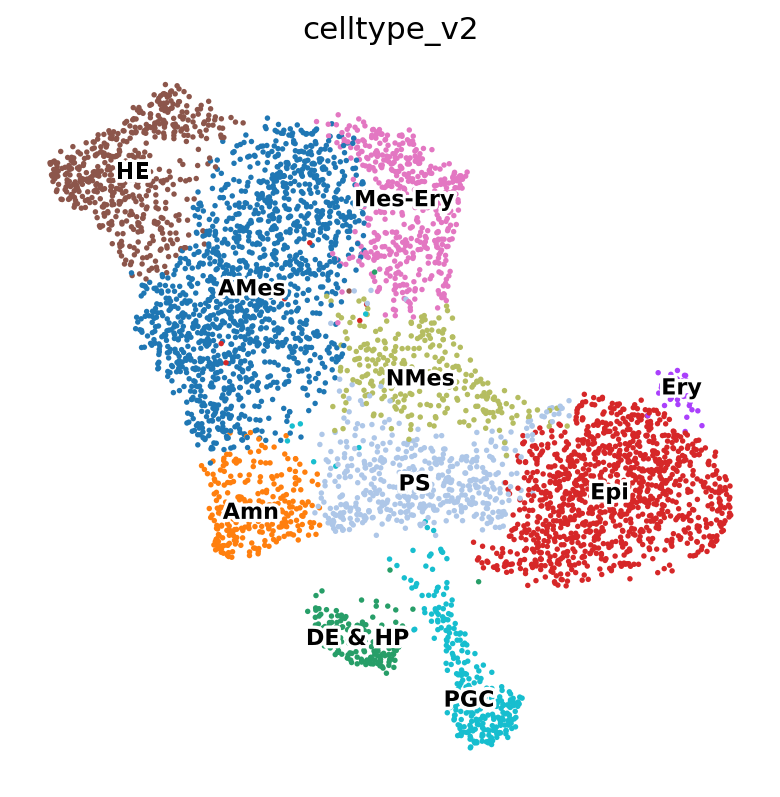

In [4]:
sc.pl.umap(adata, color=["celltype_v2"], legend_loc="on data", 
           legend_fontsize=10, legend_fontoutline=3, 
          frameon=False)

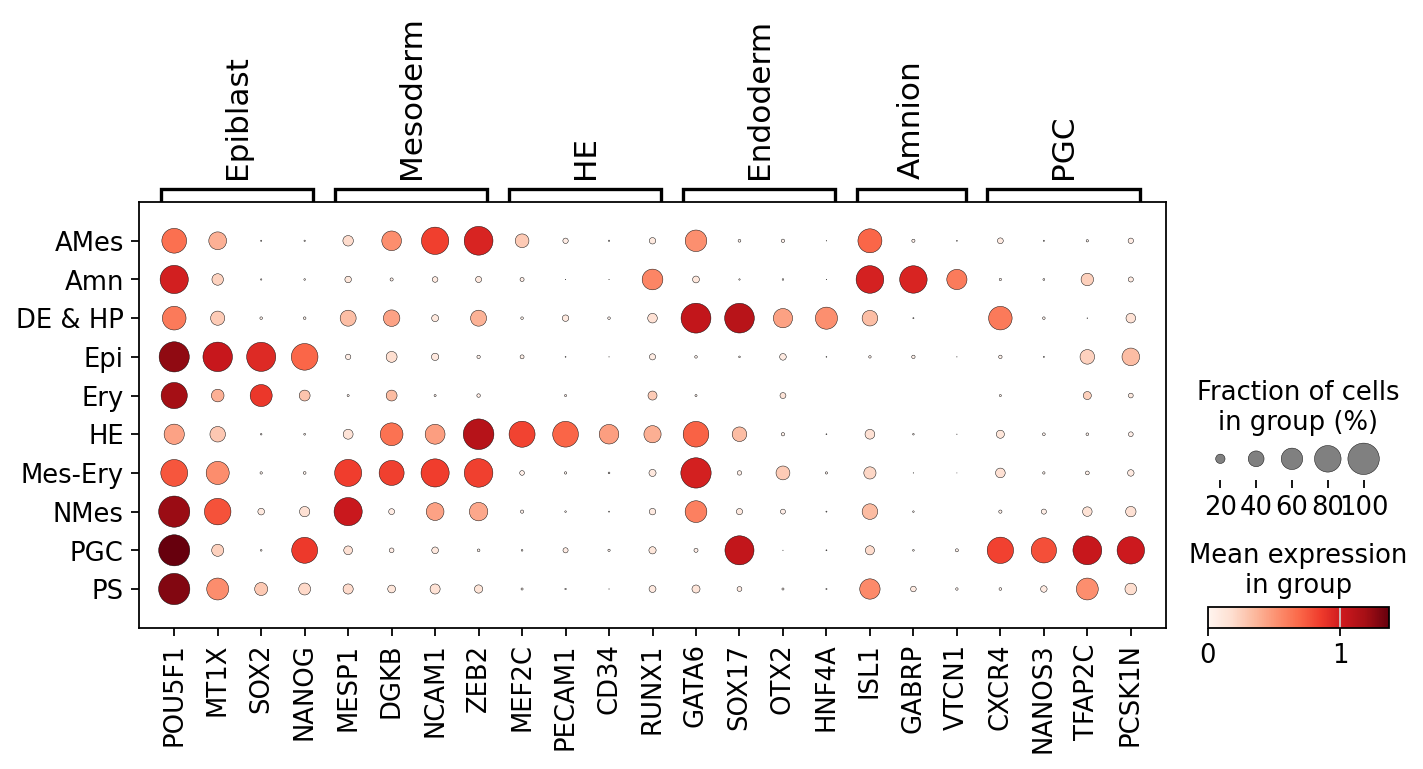

In [24]:
sc.pl.dotplot(adata, marker_genes_dict, 'celltype_v2')

In [17]:
adata.write_h5ad('/mnt/yiming/nfs_share/hema_wave/hemo-larry-d4-rna.h5ad')

## celltypist

In [2]:
import scanpy as sc
import celltypist
from celltypist import models
import time
import numpy as np
import pandas as pd

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=100,color_map='Reds')
sc.logging.print_version_and_date()

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
plt.show()
matplotlib.rcParams.update({'figure.figsize': (6,6)})

Running Scanpy 1.10.3, on 2024-11-04 18:32.


In [44]:
adata = sc.read('/mnt/yiming/nfs_share/hema_wave/hemo-larry-d4-rna.h5ad')

In [45]:
adata.obs['celltype_v2'].unique()

['AMes', 'PS', 'Amn', 'Epi', 'PGC', 'HE', 'NMes', 'Mes-Ery', 'DE & HP', 'Ery']
Categories (10, object): ['AMes', 'Amn', 'DE & HP', 'Epi', ..., 'Mes-Ery', 'NMes', 'PGC', 'PS']

### train model

In [16]:
import pyreadr

counts = pyreadr.read_r('/mnt/yiming/nfs_share/hema_wave/Tyser-2021/raw_reads.rds')
counts = counts[None]

meta = pyreadr.read_r('/mnt/yiming/nfs_share/hema_wave/Tyser-2021/umap.rds')
meta = meta[None]

In [17]:
adata_tyser = sc.AnnData(counts, obs = meta.iloc[:, 1:])

In [18]:
adata_tyser.obs_names = [f"Cell_{i:d}" for i in range(adata_tyser.n_obs)]

In [19]:
adata_tyser.obsm['X_umap'] = adata_tyser.obs[['X0', 'X1']].values

... storing 'sub_cluster' as categorical


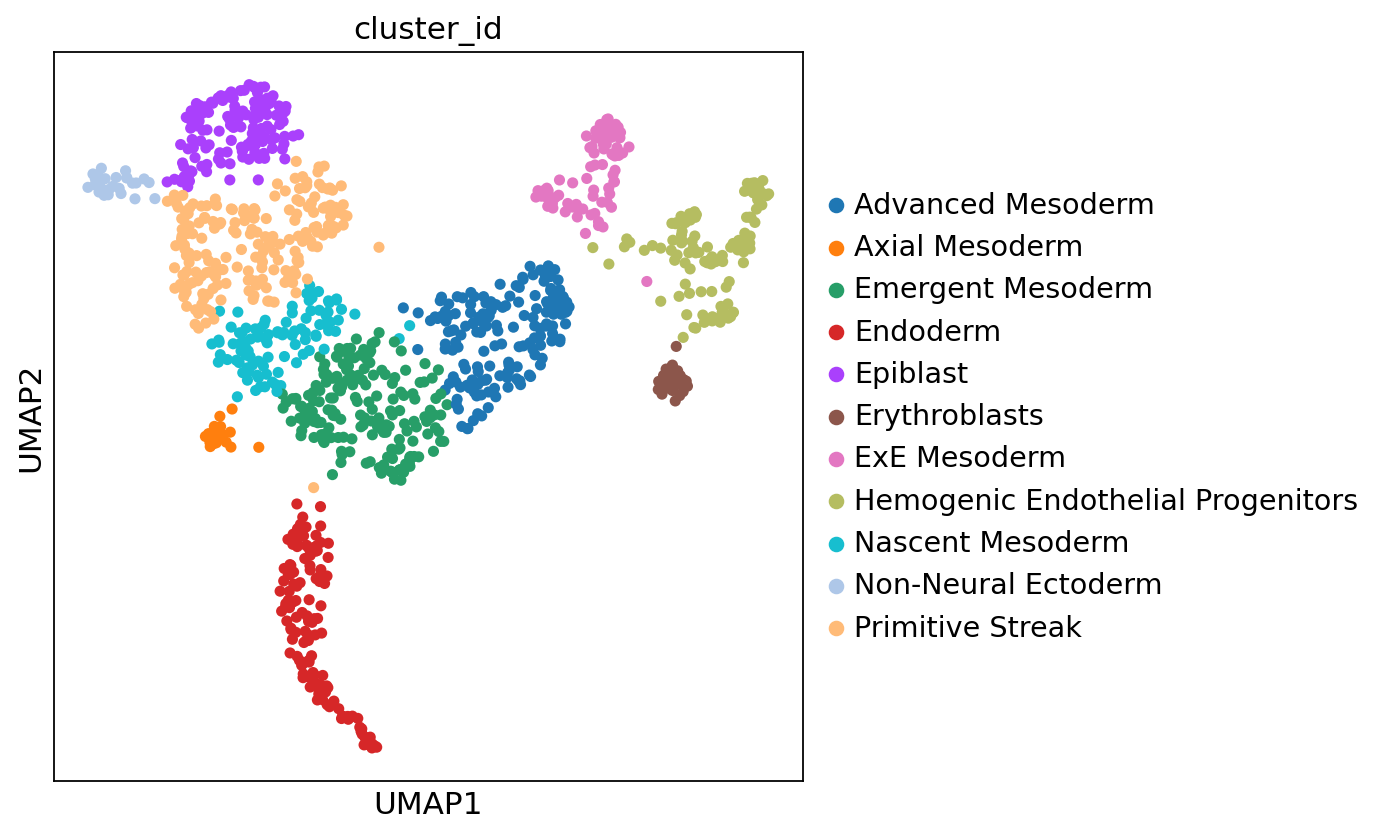

In [20]:
sc.pl.umap(adata_tyser, color=['cluster_id'])

In [21]:
sc.pp.normalize_total(adata_tyser, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(adata_tyser)

normalizing counts per cell
    finished (0:00:00)


In [22]:
adata_tyser.obs.cluster_id

Cell_0       Hemogenic Endothelial Progenitors
Cell_1                                Endoderm
Cell_2                       Advanced Mesoderm
Cell_3                        Primitive Streak
Cell_4                            ExE Mesoderm
                           ...                
Cell_1190                             Epiblast
Cell_1191                     Primitive Streak
Cell_1192                     Primitive Streak
Cell_1193                             Epiblast
Cell_1194                     Nascent Mesoderm
Name: cluster_id, Length: 1195, dtype: category
Categories (11, object): ['Advanced Mesoderm', 'Axial Mesoderm', 'Emergent Mesoderm', 'Endoderm', ..., 'Hemogenic Endothelial Progenitors', 'Nascent Mesoderm', 'Non-Neural Ectoderm', 'Primitive Streak']

In [23]:
Tyser_model_v2 = celltypist.train(adata_tyser, labels = 'cluster_id', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
✂️ 21018 non-expressed genes are filtered out
🔬 Input data has 1195 cells and 36472 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2973 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [24]:
Tyser_model_v2.write('Tyser_model_v2.pkl')

### run

In [5]:
Tyser_model_v2 = models.Model.load(model="/mnt/yiming/nfs_share/hema_wave/Tyser_model_v2.pkl")

In [6]:
Tyser_model_v2.cell_types

array(['Advanced Mesoderm', 'Axial Mesoderm', 'Emergent Mesoderm',
       'Endoderm', 'Epiblast', 'Erythroblasts', 'ExE Mesoderm',
       'Hemogenic Endothelial Progenitors', 'Nascent Mesoderm',
       'Non-Neural Ectoderm', 'Primitive Streak'], dtype=object)

In [7]:
sc.pp.normalize_total(adata, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [8]:
predictions = celltypist.annotate(adata, model=Tyser_model_v2, majority_voting=True)
predictions_adata = predictions.to_adata()
adata.obs["Tyser_label_v2"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
adata.obs["Tyser_score_v2"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

🔬 Input data has 4986 cells and 30428 genes
🔗 Matching reference genes in the model
🧬 2324 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 42 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


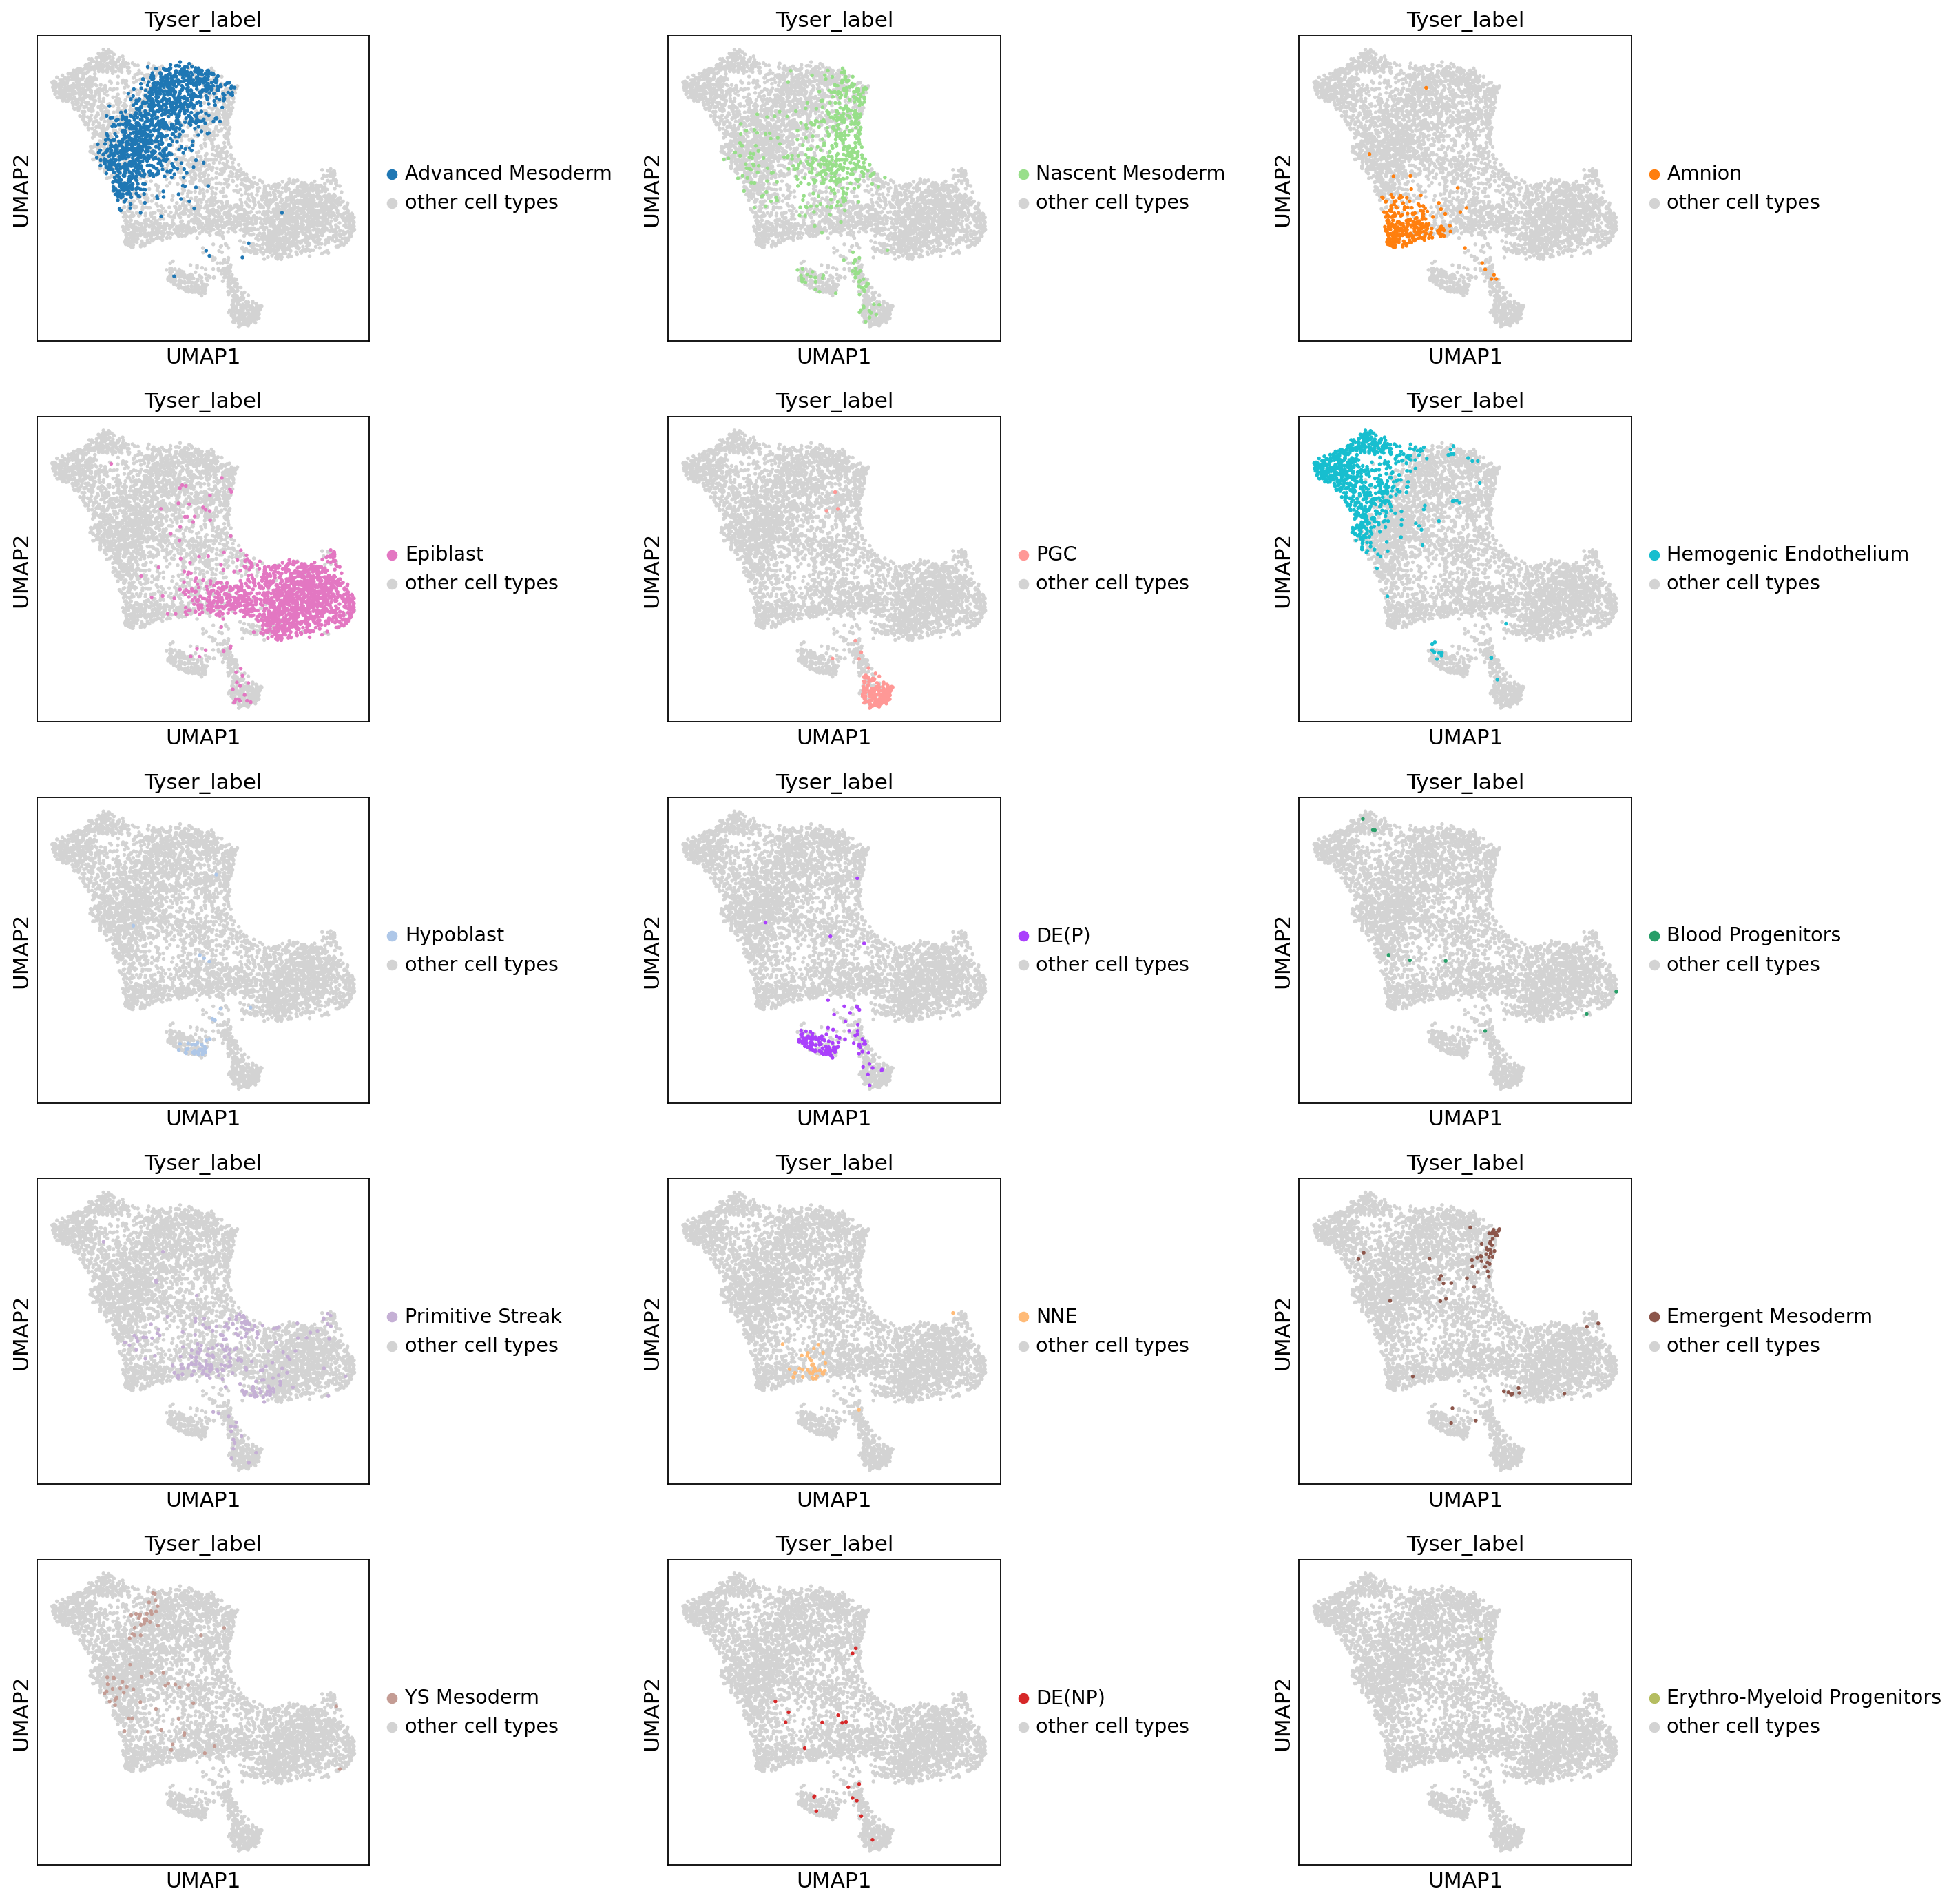

In [36]:
Tyser_label_present = adata.obs['Tyser_label'].unique()
num_plots = len(Tyser_label_present)
num_cols = 3
num_rows = -(-num_plots // num_cols) 

fig_width = num_cols * 6 
fig_height = num_rows * 3.5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

for i, label in enumerate(Tyser_label_present):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    sc.pl.umap(adata, color=["Tyser_label"], groups=[label], show=False, ax=ax)

    legend_texts = ax.get_legend().get_texts()
    for legend_text in legend_texts:
        if legend_text.get_text() == "NA":
            legend_text.set_text("other cell types")

    ax.set_aspect('auto', adjustable='box', anchor='C')

plt.tight_layout()
plt.show()

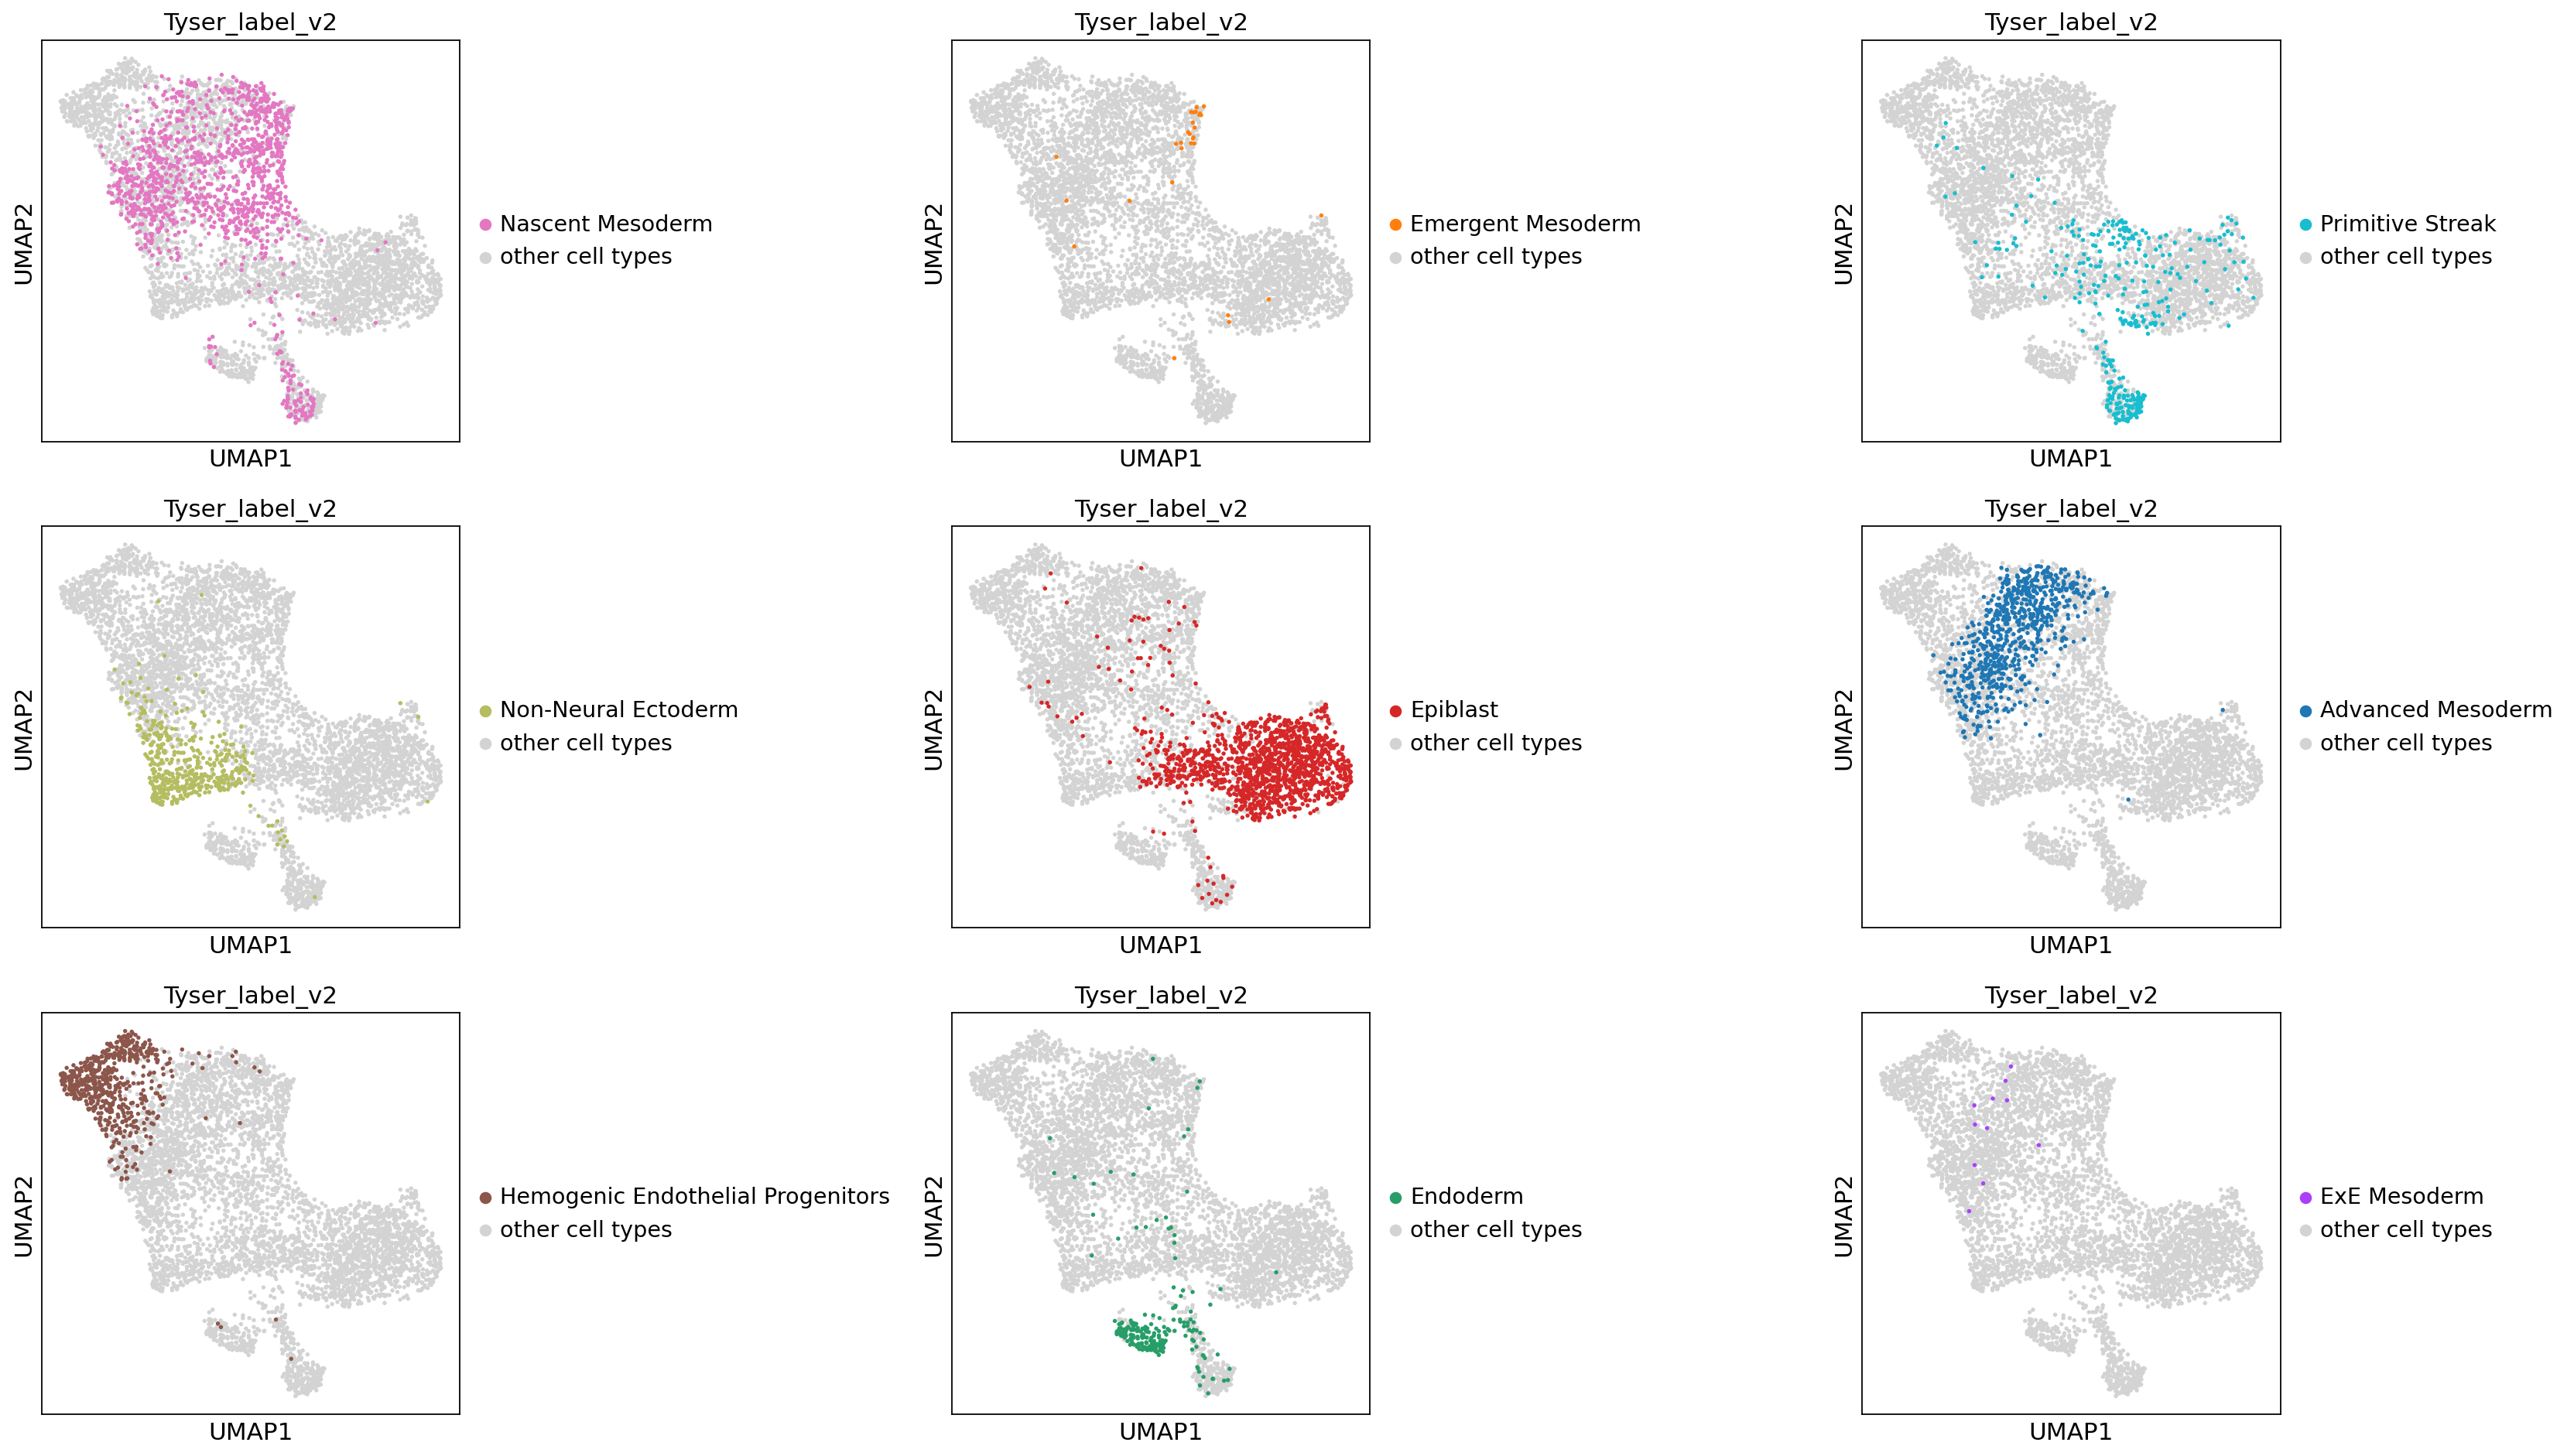

In [37]:
Tyser_label_present = adata.obs['Tyser_label_v2'].unique()
num_plots = len(Tyser_label_present)
num_cols = 3
num_rows = -(-num_plots // num_cols) 

fig_width = num_cols * 7
fig_height = num_rows * 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

for i, label in enumerate(Tyser_label_present):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    sc.pl.umap(adata, color=["Tyser_label_v2"], groups=[label], show=False, ax=ax)

    legend_texts = ax.get_legend().get_texts()
    for legend_text in legend_texts:
        if legend_text.get_text() == "NA":
            legend_text.set_text("other cell types")

    ax.set_aspect('auto', adjustable='box', anchor='C')

plt.tight_layout()
plt.show()

# clonal analysis

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=100,color_map='Reds')
sc.logging.print_version_and_date()

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
plt.show()
matplotlib.rcParams.update({'figure.figsize': (6,6)})

Running Scanpy 1.10.3, on 2025-06-19 08:08.


In [2]:
adata = sc.read_h5ad('/mnt/yiming/nfs_share/hema_wave/hemo-larry-d4-rna.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 4986 × 30428
    obs: 'scrublet_result', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype', 'celltype_v2', 'predicted_labels', 'majority_voting', 'conf_score', 'Tyser_label_v2', 'Tyser_score_v2', 'Tyser_label', 'Tyser_score', 'over_clustering', 'Xiang_label', 'Xiang_score', 'celltype_v3'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Tyser_label_colors', 'celltype_colors', 'celltype_v2_colors', 'celltype_v3_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'over_clustering', 'pca',

In [4]:
larry_barcode_orig = pd.read_csv('../larry/barcode-preprocess-d4/Larry_day-4.larry_d4_clones-240930.csv', 
                                 header=None, index_col=1)

In [5]:
# make a larry barcode_dict and map to cell barcode
barcode_dict = larry_barcode_orig[2].to_dict()
adata.obs['larry_barcode'] = adata.obs.index.map(barcode_dict)

In [6]:
# make a larry clone_dict and map to larry barcode
clone_dict = {}
clone_id = 1
for barcode in adata.obs['larry_barcode'].dropna().unique():
    clone_dict[barcode] = f'clone_{clone_id}'
    clone_id += 1

adata.obs['larry_clone'] = adata.obs['larry_barcode'].map(clone_dict)

In [7]:
adata.obs.columns

Index(['scrublet_result', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden',
       'celltype', 'celltype_v2', 'predicted_labels', 'majority_voting',
       'conf_score', 'Tyser_label_v2', 'Tyser_score_v2', 'Tyser_label',
       'Tyser_score', 'over_clustering', 'Xiang_label', 'Xiang_score',
       'celltype_v3', 'larry_barcode', 'larry_clone'],
      dtype='object')

In [8]:
adata = adata[~adata.obs['larry_clone'].isnull()]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 4618 × 30428
    obs: 'scrublet_result', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype', 'celltype_v2', 'predicted_labels', 'majority_voting', 'conf_score', 'Tyser_label_v2', 'Tyser_score_v2', 'Tyser_label', 'Tyser_score', 'over_clustering', 'Xiang_label', 'Xiang_score', 'celltype_v3', 'larry_barcode', 'larry_clone'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Tyser_label_colors', 'celltype_colors', 'celltype_v2_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'over_c

## cospar for lineage inference

In [10]:
import cospar as cs
import pandas as pd
import scipy.io as sio
import numpy as np
import os

In [11]:
cs.logging.print_version()

# Set the messaging level. At a given value, a running function will
# print information at or below its level.
cs.settings.verbosity = 2  # range: 0 (error),1 (warning),2 (info),3 (hint).

# Plot setting. If you want to control a particular plot,
# just change the setting here, and run that plotting function.
cs.settings.set_figure_params(
    format="png", figsize=[4, 3.5], dpi=75, fontsize=14, pointsize=3
)

Running cospar 0.3.4 (python 3.11.10) on 2025-06-19 08:08.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [12]:
adata_raw = sc.read_10x_h5('/mnt/yiming/nfs_share/larry/Larry-D4/outs/filtered_feature_bc_matrix.h5')

reading /mnt/yiming/nfs_share/larry/Larry-D4/outs/filtered_feature_bc_matrix.h5
 (0:00:02)


In [13]:
adata_raw.X

<5566x38606 sparse matrix of type '<class 'numpy.float32'>'
	with 37597446 stored elements in Compressed Sparse Row format>

In [14]:
adata_raw = adata_raw[adata_raw.obs.index.isin(adata.obs.index)]

In [15]:
adata_raw.obs['state_info'] = adata.obs['celltype_v2']

In [16]:
adata_raw.obsm['X_emb'] = adata.obsm['X_umap']

In [17]:
adata_raw.uns['data_des'] = 'larry-d4'

In [18]:
adata_raw

AnnData object with n_obs × n_vars = 4618 × 38606
    obs: 'state_info'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'data_des'
    obsm: 'X_emb'

In [19]:
df_X_clone = adata.obs[['larry_clone']]
cell_ids = [f'cell_{i+1}' for i in range(len(df_X_clone))]

df_X_clone['Cell_ID'] = cell_ids
df_X_clone.rename(columns={'larry_clone': 'Clone_ID'}, inplace=True)

In [20]:
adata_raw.obs_names = cell_ids

In [21]:
cs.pp.get_X_clone(adata_raw, df_X_clone["Cell_ID"], df_X_clone["Clone_ID"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4618/4618 [00:00<00:00, 1479362.70it/s]

reorder clones


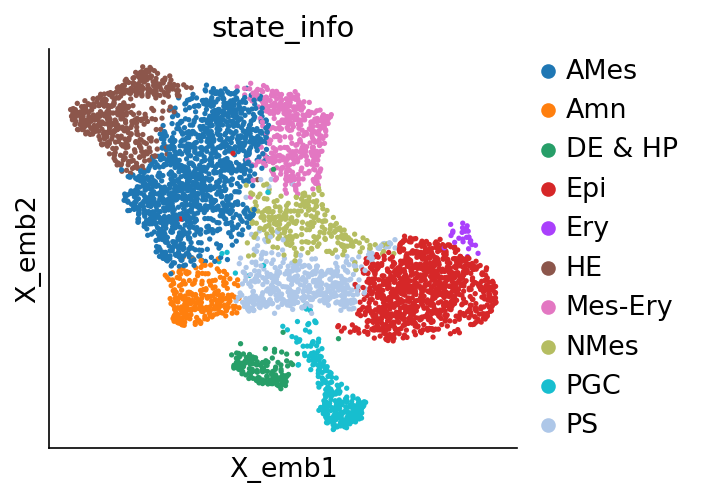

In [22]:
cs.pl.embedding(adata_raw, color="state_info")

## preprocessing

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
Finding highly variable genes...


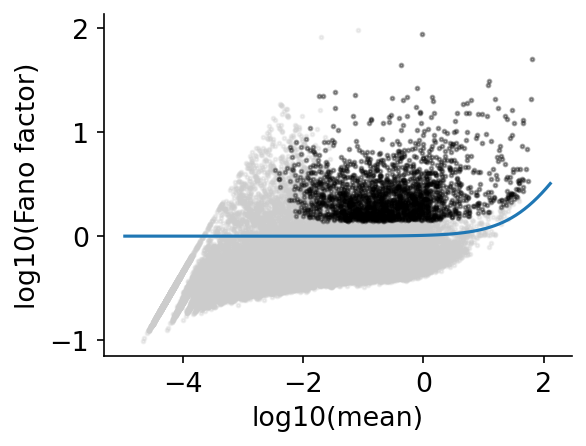

Keeping 1995 genes


In [23]:
cs.pp.get_highly_variable_genes(
    adata_raw,
    normalized_counts_per_cell=10000,
    min_counts=3,
    min_cells=3,
    min_gene_vscore_pctl=90,
)

In [24]:
# cs.pp.remove_cell_cycle_correlated_genes(
#     adata_raw,
#     cycling_gene_list=[
#         'CDK7', 'CDKN1A', 'CDKN1B'
#     ],
# )

In [25]:
adata_raw.var_names_make_unique()

In [26]:
cs.pp.get_X_pca(adata_raw, n_pca_comp=40)
cs.pp.get_X_emb(adata_raw, n_neighbors=20, umap_min_dist=0.3)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


In [27]:
adata_raw

AnnData object with n_obs × n_vars = 4618 × 38606
    obs: 'state_info', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'data_des', 'clone_id', 'state_info_colors', 'neighbors', 'umap'
    obsm: 'X_emb', 'X_clone', 'X_pca', 'X_umap', 'X_emb_old'
    obsp: 'distances', 'connectivities'

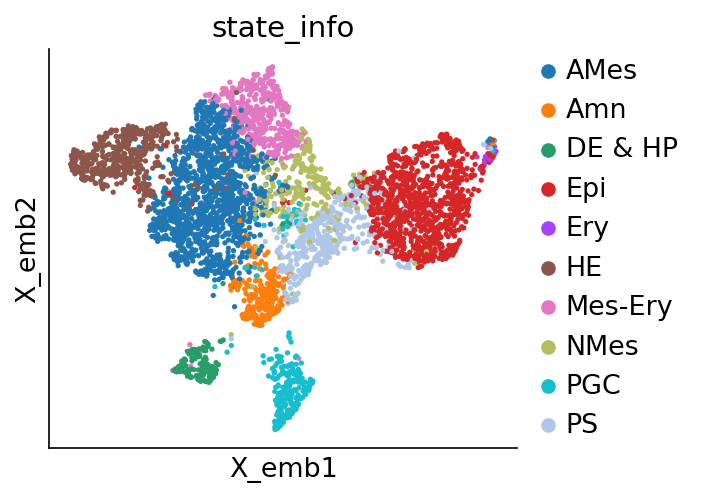

In [28]:
cs.pl.embedding(adata_raw, color="state_info")

In [29]:
adata_raw.obs['state_info']

cell_1          AMes
cell_2           Amn
cell_3           Epi
cell_4           Epi
cell_5            PS
              ...   
cell_4614        Epi
cell_4615    DE & HP
cell_4616        Epi
cell_4617       AMes
cell_4618        Epi
Name: state_info, Length: 4618, dtype: category
Categories (10, object): ['AMes', 'Amn', 'DE & HP', 'Epi', ..., 'Mes-Ery', 'NMes', 'PGC', 'PS']

In [30]:
adata_raw.obs['time_info'] = '4'

In [31]:
adata_raw.obs['state_info'].cat.categories

Index(['AMes', 'Amn', 'DE & HP', 'Epi', 'Ery', 'HE', 'Mes-Ery', 'NMes', 'PGC',
       'PS'],
      dtype='object')

In [32]:
cs.settings.set_figure_params(
    format="png", figsize=[6, 6], dpi=100, fontsize=14, pointsize=3
)

Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '2626 clones'}>

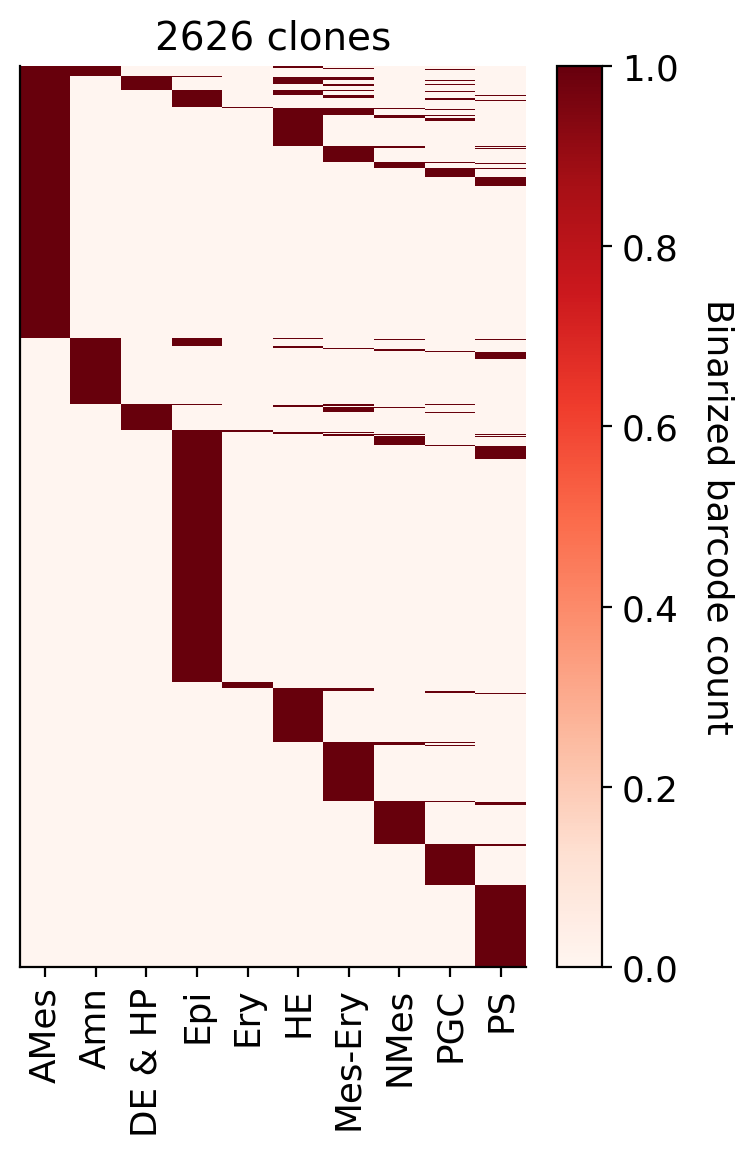

In [33]:
selected_times = None
selected_fates = adata_raw.obs['state_info'].cat.categories
celltype_names = adata_raw.obs['state_info'].cat.categories
cs.pl.barcode_heatmap(
    adata_raw,
    selected_times=selected_times,
    selected_fates=selected_fates,
    color_bar=True,
    rename_fates=celltype_names,
    log_transform=False,
    binarize=True,
)

In [34]:
cs.settings.set_figure_params(
    format="png", figsize=[5, 5], dpi=100, fontsize=14, pointsize=3
)

normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
Results saved as dictionary at adata.uns['fate_coupling_X_clone']


<Axes: title={'center': 'source: X_clone'}>

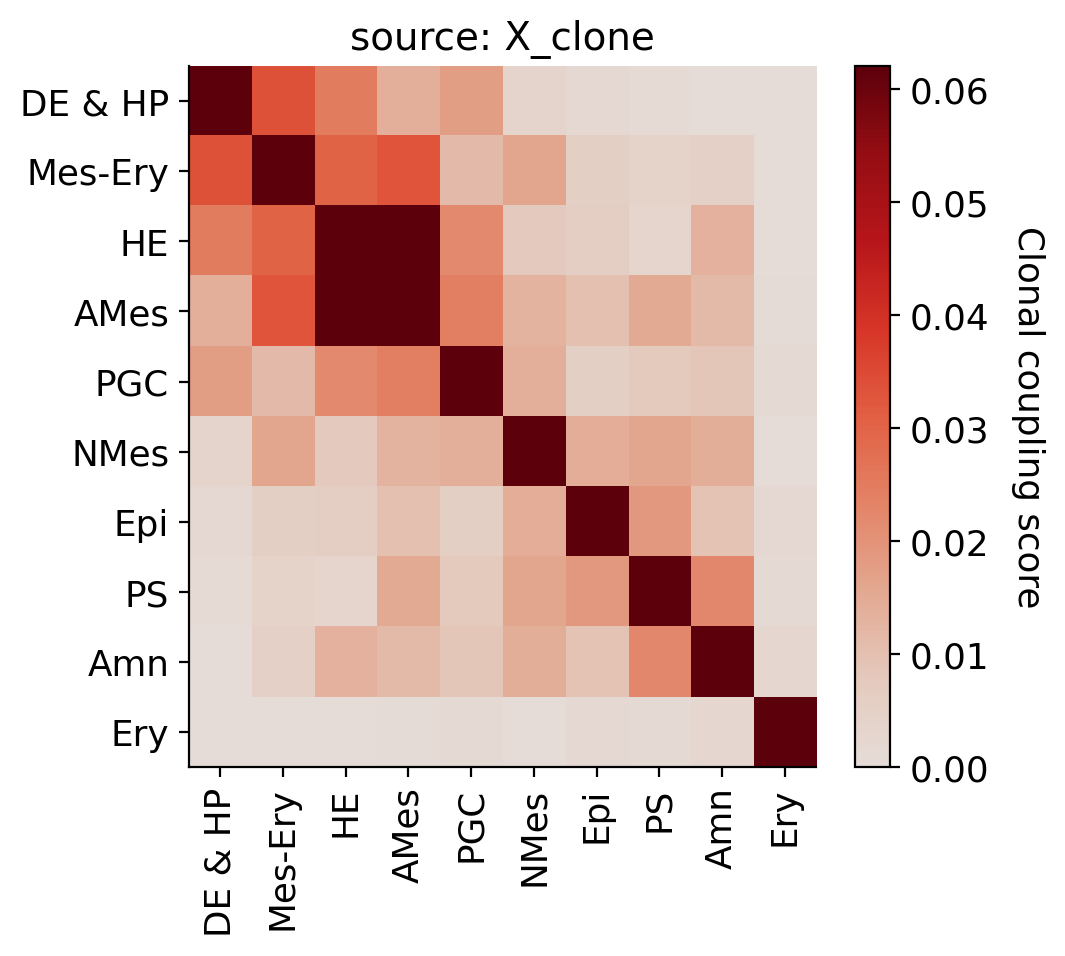

In [35]:
cs.tl.fate_coupling(
    adata_raw, selected_fates=selected_fates, source="X_clone"
)  # compute the fate coupling
cs.pl.fate_coupling(adata_raw, source="X_clone")  # actually plot the coupling

In [36]:
cs.tl.fate_hierarchy(
    adata_raw, selected_fates=selected_fates, source="X_clone"
)  # compute the fate hierarchy
cs.pl.fate_hierarchy(adata_raw, source="X_clone")  # actually plot the hierarchy

normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
Results saved as dictionary at adata.uns['fate_hierarchy_X_clone']

                  /-PS
               /-|
            /-|   \-Amn
           |  |
           |   \-Epi
           |
         /-|         /-HE
        |  |      /-|
        |  |   /-|   \-A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2626/2626 [00:03<00:00, 717.70it/s]


Data saved at adata.uns['clonal_fate_bias']


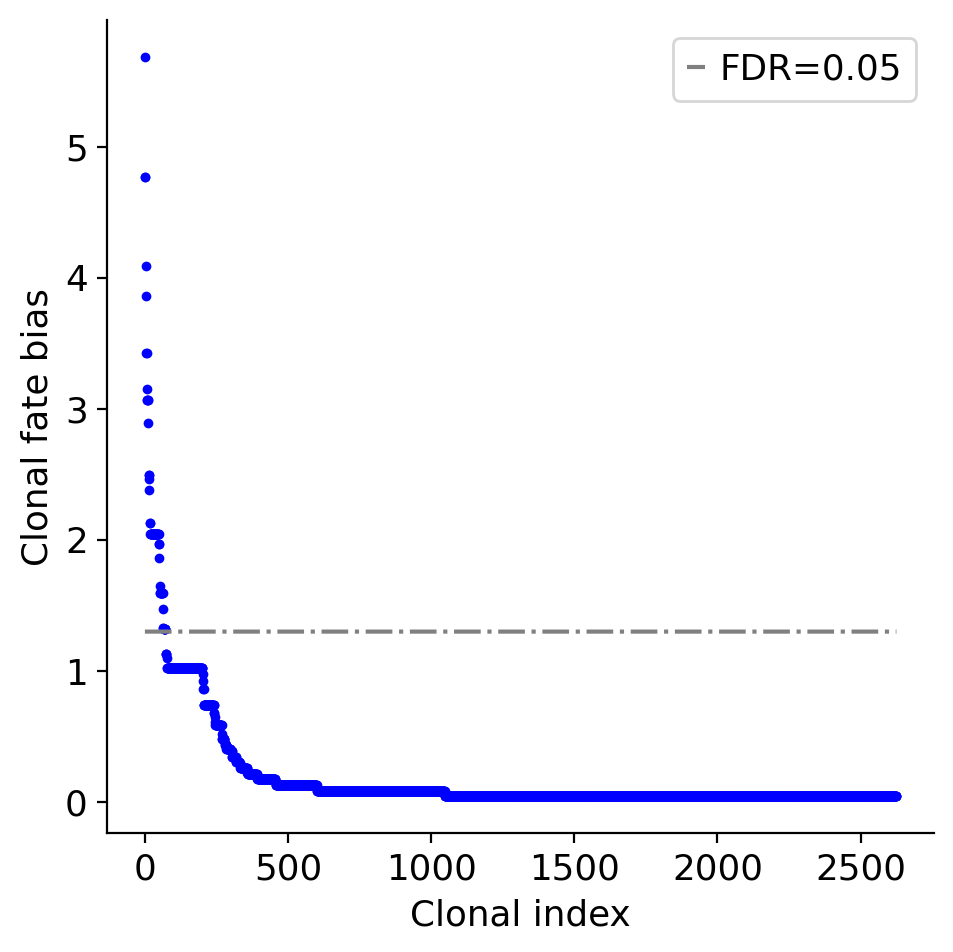

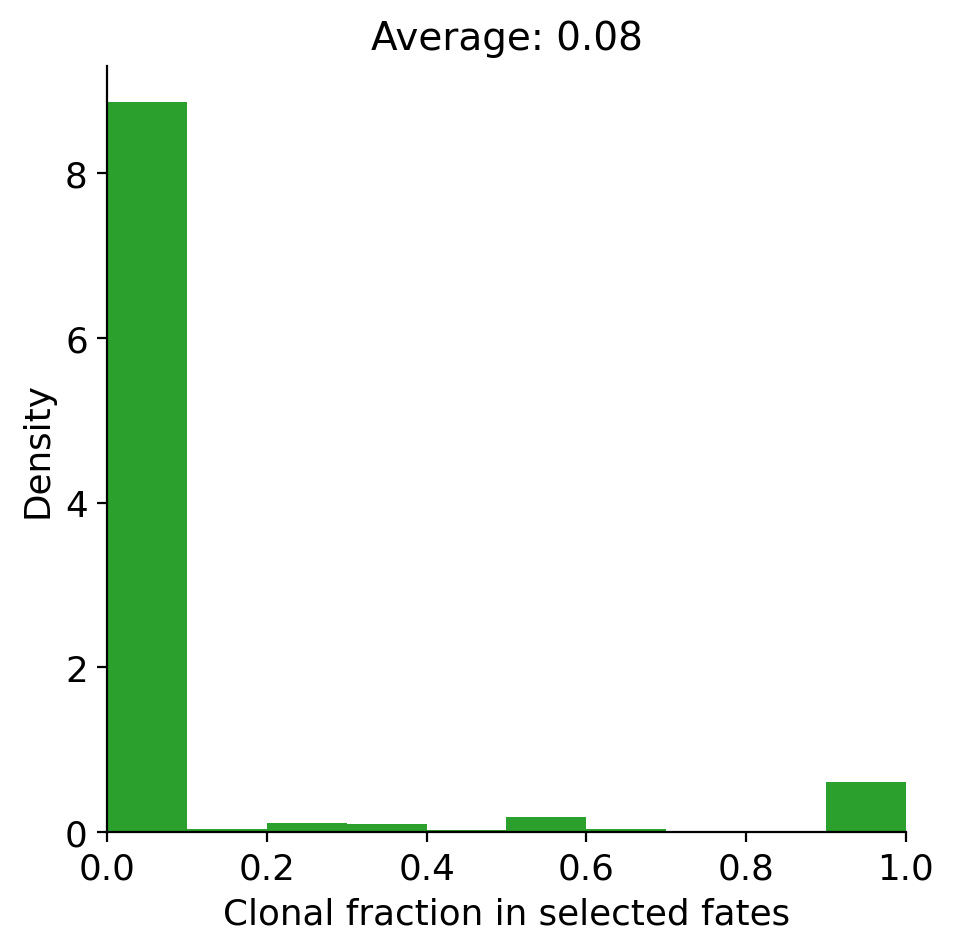

In [37]:
cs.tl.clonal_fate_bias(
    adata_raw, selected_fate="Mes-Ery", alternative="two-sided"
)  # compute the fate hierarchy
cs.pl.clonal_fate_bias(adata_raw)  # actually plot the hierarchy